In [455]:
# link to use: https://towardsdatascience.com/faq-build-a-handwritten-text-recognition-system-using-tensorflow-27648fb18519
# convert image to character segments: https://stackoverflow.com/questions/10964226/how-to-convert-an-image-into-character-segments
# KMNIST convolutional NN: https://github.com/rois-codh/kmnist/blob/master/benchmarks/kuzushiji_mnist_cnn.py


# DOWNLOAD THE KMNIST DATA BEFORE RUNNING THIS NOTEBOOK
https://github.com/rois-codh/kmnist/

## Preprocessing: Image Segmentation and Contrast Enhancement

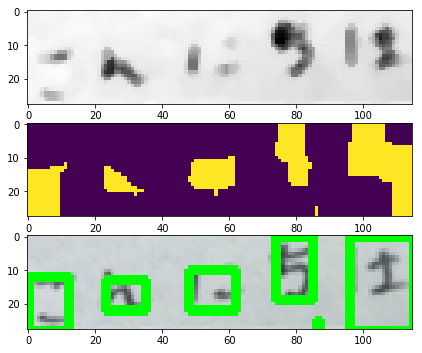

In [334]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from scipy.stats import mode


# Load the image
img = cv2.imread('hi.png')
img = np.append(img,[img[0]],axis = 0)

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# smooth the image to avoid noises
gray = cv2.medianBlur(gray,5)

# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(gray,255,1,1,61,2)
thresh_color = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

# apply some dilation and erosion to join the gaps
# thresh = cv2.dilate(thresh,None,iterations = 3)
# thresh = cv2.erode(thresh,None,iterations = 2)

# clean up the neighbours
# majority based label cleanup
#plt.imshow(thresh)
def cleanup(img):
    clean = np.zeros(np.shape(img))
    print(np.shape(img))
    for i in range(1, len(img)-1):
        for j in range(1, len(img[0])-1):
            neighbors = [img[i][j-1], 
                         img[i][j+1], 
                         img[i-1][j+1], 
                         img[i-1][j-1], 
                         img[i-1][j], 
                         img[i+1][j],
                         img[i+1][j+1], 
                         img[i+1][j-1]]
            if img[i][j] != 0 and 0 in neighbors:
                clean[i][j] = 0
            else:
                clean[i][j] = img[i][j]
    return clean

# thresh = cleanup(thresh)
# print(type(thresh))
# plt.imshow(thresh)


thresh = cv2.dilate(thresh,None, iterations = 4, anchor = (0, 1))
thresh = cv2.erode(thresh,None, iterations = 5)


fig = plt.figure(figsize=(10,10))
fig.add_subplot(5,1,1)
plt.imshow(gray, cmap = "gray")
fig.add_subplot(5,1,2)
plt.imshow(thresh)

# Find the contours
im, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

# # For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.rectangle(thresh_color,(x,y),(x+w,y+h),(0,255,0),2)

fig.add_subplot(5,1,3)
plt.imshow(img)


# CNN for Hiragana Classification using KMNIST-49

In [174]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np

batch_size = 128
num_classes = 49
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('kmnist/k49-train-imgs.npz')
x_test = load('kmnist/k49-test-imgs.npz')
y_train = load('kmnist/k49-train-labels.npz')
y_test = load('kmnist/k49-test-labels.npz')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('{} train samples, {} test samples'.format(len(x_train), len(x_test)))

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

232365 train samples, 38547 test samples
Train on 232365 samples, validate on 38547 samples
Epoch 1/1
232365/232365 [==============================] - 866s 4ms/step - loss: 0.9502 - acc: 0.7507 - val_loss: 0.6896 - val_acc: 0.8195
Train loss: 0.3191068475342827
Train accuracy: 0.9149355539778349
Test loss: 0.6895805723250205
Test accuracy: 0.8194930863574645


In [458]:
x = model.predict(x_test)

(38547, 28, 28, 1)
ん


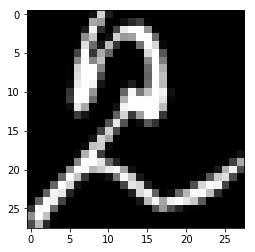

In [461]:
print(np.shape(x_test))
plt.imshow(x_test[3,:,:,0], cmap = "gray")
print(map_unicode[np.argmax(x[3])])

In [462]:
# create mappings from num to unicode, and syllable to unicode
map_unicode = {
    0:  u"\u3042", 1:  u"\u3044", 2:  u"\u3046", 3:  u"\u3048", 4:  u"\u304A",
    5:  u"\u304B", 6:  u"\u304D", 7:  u"\u304F", 8:  u"\u3051", 9:  u"\u3053",
    10: u"\u3055", 11: u"\u3057", 12: u"\u3059", 13: u"\u305B", 14: u"\u305D",
    15: u"\u305F", 16: u"\u3061", 17: u"\u3064", 18: u"\u3066", 19: u"\u3068",
    20: u"\u306A", 21: u"\u306B", 22: u"\u306C", 23: u"\u306D", 24: u"\u306E",
    25: u"\u306F", 26: u"\u3072", 27: u"\u3075", 28: u"\u3078", 29: u"\u307B",
    30: u"\u307E", 31: u"\u307F", 32: u"\u3080", 33: u"\u3081", 34: u"\u3082",
    35: u"\u3084", 36: u"\u3086", 37: u"\u3088", 38: u"\u3089", 39: u"\u308A",
    40: u"\u308B", 41: u"\u308C", 42: u"\u308D", 43: u"\u308F", 44: u"\u3090",
    45: u"\u3091", 46: u"\u3092", 47: u"\u3093", 48: u"\u309D"}

print([map_unicode[i] for i in range(49)])

chars = ["a", "i", "u", "e", "o",
         "ka", "ki", "ku", "ke", "ko",
         "sa", "shi", "su", "se", "so",
         "ta", "chi", "tsu", "te", "to",
         "na", "ni", "nu", "ne", "no",
         "ha", "hi", "fu", "he", "ho",
         "ma", "mi", "mu", "me", "mo",
         "ya", "yu", "yo",
         "ra", "ri", "ru", "re", "ro",
         "wa", "wi", "wu", "wo",
         "n"]

map_unicode_char = dict()
for i in range(len(chars)):
    map_unicode_char[chars[i]] = map_unicode[i] 
    
print(map_unicode_char)


['あ', 'い', 'う', 'え', 'お', 'か', 'き', 'く', 'け', 'こ', 'さ', 'し', 'す', 'せ', 'そ', 'た', 'ち', 'つ', 'て', 'と', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ひ', 'ふ', 'へ', 'ほ', 'ま', 'み', 'む', 'め', 'も', 'や', 'ゆ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ゝ']
{'a': 'あ', 'i': 'い', 'u': 'う', 'e': 'え', 'o': 'お', 'ka': 'か', 'ki': 'き', 'ku': 'く', 'ke': 'け', 'ko': 'こ', 'sa': 'さ', 'shi': 'し', 'su': 'す', 'se': 'せ', 'so': 'そ', 'ta': 'た', 'chi': 'ち', 'tsu': 'つ', 'te': 'て', 'to': 'と', 'na': 'な', 'ni': 'に', 'nu': 'ぬ', 'ne': 'ね', 'no': 'の', 'ha': 'は', 'hi': 'ひ', 'fu': 'ふ', 'he': 'へ', 'ho': 'ほ', 'ma': 'ま', 'mi': 'み', 'mu': 'む', 'me': 'め', 'mo': 'も', 'ya': 'や', 'yu': 'ゆ', 'yo': 'よ', 'ra': 'ら', 'ri': 'り', 'ru': 'る', 're': 'れ', 'ro': 'ろ', 'wa': 'わ', 'wi': 'ゐ', 'wu': 'ゑ', 'wo': 'を', 'n': 'ん'}


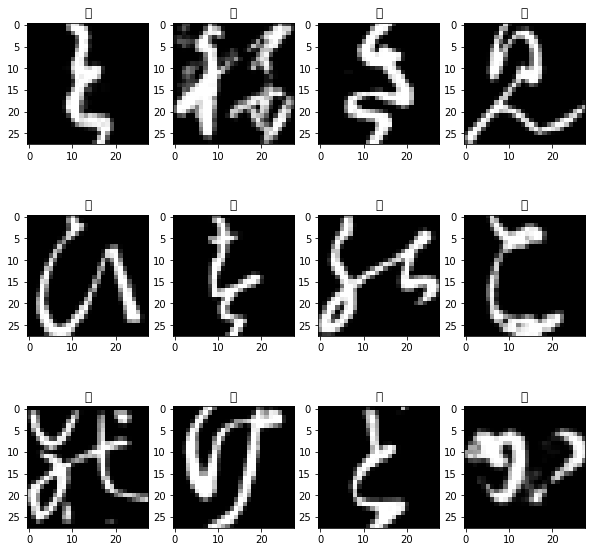

In [280]:
# -*- coding: utf-8 -*-
fig = plt.figure(figsize=(10,10))

for i in range(12):
    fig.add_subplot(3,4,i+1)
    plt.imshow(x_test[i,:,:,0], cmap = "gray")
    plt.title(chars[i])
    


19 と


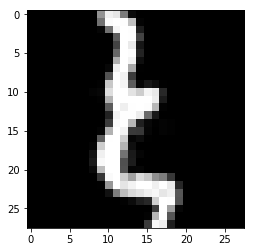

In [467]:
subject = x_test[0].reshape(1,28,28,1)
plt.imshow(subject[0,:,:,0], cmap = "gray")
y = model.predict(subject)
print(np.argmax(y), map_unicode[19])

top 3 character numbers:  7 ,  9 ,  5
top 3 results for  ko :  く ,  こ ,  か
top 3 character numbers:  25 ,  47 ,  48
top 3 results for  n :  は ,  ん ,  ゝ
top 3 character numbers:  25 ,  38 ,  12
top 3 results for  ni :  は ,  ら ,  す
top 3 character numbers:  11 ,  30 ,  17
top 3 results for  chi :  し ,  ま ,  つ
top 3 character numbers:  13 ,  8 ,  33
top 3 results for  wa :  せ ,  け ,  め


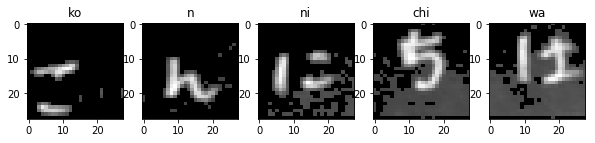

In [472]:
# data cleanup

def set_pix(im):
    for i in range(len(im)):
        for j in range(len(im[0])):
            val = 1-im[i][j]/255
            if val <= .2:
                im[i][j] = 0.0
            else:
                im[i][j] = val
    return im
 
def format_char(lo, hi):
    char = img[:,lo:hi,:]
    if lo == 0:
        char[:,22:,:] = char[:,16:22,:]

    char = cv2.cvtColor(char,cv2.COLOR_BGR2GRAY)
    char = np.array(char, dtype=object)
    char = set_pix(char)

    char = char.reshape(1,28,28,1)
    char = np.array(char, dtype="float32")
    
    pic = char[0,:,:,0]
    return char, pic

##### get letters from image ##########

## TODO: USE SEGMENTATIONS
## prevent false positives
## get number of pix in bounding box
## smallest must have at least 2/3 largest
## cv2.reshape? to get it to 28 x 28
    
## ko
img = cv2.imread('hi.png')
img = np.append(img,[img[0]],axis = 0)
ko, im_ko = format_char(0, 28)

## n
img = cv2.imread('hi.png')
img = np.append(img,[img[0]],axis = 0)
n, im_n = format_char(15,43)

## ni
ni, im_ni = format_char(43, 71)

## chi
chi, im_chi = format_char(65, 93)

## wa
wa, im_wa = format_char(87, 115)


##### Predictions ##########

def predict_char(char, name):
    pred = model.predict(char)
    
    sort = pred.argsort()[0]
    res = sort[-1]
    snd = sort[-2]
    thr = sort[-3]
    
#     if name == "chi":
#         # 31 hmm
#         print(pred)
#         print(sort)
#         print(max(pred[0]),pred[0][16])
#         print(49-np.where(sort == 16)[0])
    
#     if name == "wa":
#         # 31 hmm
#         print(pred)
#         print(sort)
#         print(max(pred[0]),pred[0][25])
#         print(49-np.where(sort == 25)[0])
    
    m1 = map_unicode[res] 
    m2 = map_unicode[snd]
    m3 = map_unicode[thr]
    
    print("top 3 character numbers: ", res, ", ", snd, ", ", thr)
    print("top 3 results for ",name, ": ", m1, ", ", m2, ", ", m3 )

predict_char(ko, "ko")
predict_char(n, "n")
predict_char(ni, "ni")
predict_char(chi, "chi")
predict_char(wa, "wa")

# print(map_unicode[16])


##### Display ##########

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,5,1)
plt.imshow(im_ko, cmap = "gray")
plt.title("ko")
fig.add_subplot(1,5,2)
plt.imshow(im_n, cmap = "gray")
plt.title("n")
fig.add_subplot(1,5,3)
plt.imshow(im_ni, cmap = "gray")
plt.title("ni")
fig.add_subplot(1,5,4)
plt.imshow(im_chi, cmap = "gray")
plt.title("chi")
fig.add_subplot(1,5,5)
plt.imshow(im_wa, cmap = "gray")
plt.title("wa");



In [454]:
##### TRANSLATION ######
from googletrans import Translator

translator = Translator()

#word = ["to", "te", "mo", "ya", "sa", "shi", "i", "hi", "to"]
#word = ["wa", "ta", "shi", "no", "na", "ma", "e", "ha"]
word = ["wa", "ta", "shi", "te"]
string = "".join([map_unicode_char[st] for st in word])
print(string)

print(translator.translate(string).extra_data["possible-translations"][0][2])

わたして
[['hand it over', 1000, True, False], ['pass', 1000, True, False], ['Me', 0, True, False], ['Te I', 0, True, False]]
